<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Cross entropy and KL divergence</div>

Sébastien Popineau

1. [Motivations behind Cross entropy](#sec1)
    1. [Intuition behind Entropy](#sec1-1)
    2. [Now on to Cross Entropy !](#sec1-2)
    3. [Kullback-Leibler Divergence](#sec1-3)
2. [Cross-entropy in Machine Learning](#sec2)
    1. [Concepts behind classifications](#sec2-1)
    2. [One loss to rule them all](#sec2-2)
3. [Intuition for using Cross-entropy in ML problems](#sec3)
    1. [Exploring the question in a binary classification problem](#sec3-1)
    2. [Interpreting cross-entropy](#sec3-2)
4. [Bibliography](#sec4)

In [3]:
# loading requirements

!pip install keras
import numpy as np
import math
from math import log
from keras import backend
from keras.losses import binary_crossentropy
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot

You should consider upgrading via the '/Users/seb/anaconda3/bin/python -m pip install --upgrade pip' command.


# <a id="sec1"></a> 1. Motivations behind cross entropy 

In Machine Learning, cross-entropy is very commonly used as a cost function when training classifiers and so we’ll see why that is. 

Before diving into details, we will first give a larger introduction on the matter.

Those concepts come from Claude Shannon’s Information Theory. Shannon was an American
mathematician, electrical engineer, and cryptographer. And in his 1948 paper “A Mathematical Theory
of Communication” he founded what is now known as Information Theory. 
**The goal is to reliably and efficiently transmit a message from a sender to a recipient.** 

You already know that a bit is either equal to 0 or 1 ; but not all bits are useful: some of them are redundant, some of them are errors ... 
Therefore when we communicate a message, we want as much useful information as possible to get through.

In Shannon’s theory, to transmit one bit of information means to reduce the recipient’s uncertainty by a factor of 2.

<img src="pictures/shannon.jpg" width="400">

## <a id="sec1-1"></a> 1.1 Intuition behind Entropy

To better undestand what mecanics are at work behind this topic, we will use a typical weather forecast example.

Say that you live in Bourg-en-Bresse, the weather is completely random, with a 50/50 chance of being either sunny or rainy every day.


<img src="pictures/sun-rain.png" width="400">

If a weather station tells you that it’s going to be rainy tomorrow then they have actually reduced your uncertainty by a factor of two (there were two equally likely options, now there is just one).

So the weather channel actually **sent you a single bit of useful information**. 
NB : and this is true no matter how they encoded this information.
If they encoded it as a string, "rainy" with 5 characters, each encoded on 1 byte, then they actually sent you a 40 bit message, but they still only communicated 1 bit of useful information.<br>


Now suppose the weather has actually 8 possible states, all equally likely.

<img src="pictures/8-states.png" width="400">

Now when the weather station gives you tomorrow’s weather, they are dividing your uncertainty by a factor of 8, which is 2 to the power of 3. So they sent you 3 bits of useful information.
**To find the number of bits of information that were actually communicated, we compute the binary logarithm of the uncertainty reduction factor, which in this example is 8.**

In [4]:
def b_log(x):
    return math.log(x,2)

In [5]:
b_log(8)

3.0

But what if the possibilities are not equally likely? Say 75% chance sunny, and 25% chance rainy.

<img src="pictures/sun-rain-25.png" width="400">

<div class="alert alert-warning">

**Exercice:**<br>
Find the number of bits of information that will be sent in the two scenarios (when the station tells you it's going to rain, and when the station tells you it will be sunny). Remember that we use the uncertainty reduction factor, so first think at how is uncertainty affected in each scenario ?
</div>

In [25]:
# %load solutions/code1.py
# Uncomment and run the loading, then execute what you just loaded

<div class="alert alert-info">
<a href="#code1" data-toggle="collapse">
    
**Solution note (click to unfold):**</a><br/>
<div id="code1" class="collapse">
If the weather station tells you it’s going to be rainy tomorrow, then your uncertainty has dropped by a factor of 4, which is 2 bits of information. In the same way, your uncertainty will drop by a factor of 1/0.75 when it tells you it will be sunny.
</div>
</div>

<div class= "alert alert-success">
    
**The uncertainty reduction is just the inverse of the event’s probability**.
Now the log of 1/x is equal to -log(x), so the equation to compute the number of bits simplifies to : 
    
\begin{align*}
-\log(\mathbb{P}( forecast ))
\end{align*}
<br>
    
If the weather station tells you it’s going to be sunny tomorrow then your uncertainty hasn’t dropped much : you get just over .42 bits of information. Whereas when it tells you it will be rainy, you need 2 bits of information.
    
</div>

<div class="alert alert-warning">

**Exercice:**<br>
So how much information are you actually going to get from the weather station, on average ?

<div class="alert alert-info"><a href="#code2" data-toggle="collapse">
    
**Solution note (click to unfold):** </a><br/>
<div id="code2" class="collapse">
There’s a 75% chance that it will be sunny tomorrow, so that’s what the weather
station would tell you and that’s .41 bits of information.
Then there’s a 25% chance that it will be rainy, in which case the weather station will
tell you so, and this will give you 2 bits of information.</div>
</div>


In [ ]:
# %load solutions/code2.py
# Uncomment and run the loading, then execute what you just loaded

**We just computed the Entropy. It is a nice measure of how uncertain the events are.** (more specifically the average amount of information that you get from one sample drawn from a given probability
distribution p).


<div class= "alert alert-success">
    
**Entropy :**

\begin{align*}
H(p)=-\sum \limits_{i} p_{i} log_{2}(p_{i})
\end{align*}


## <a id="sec1-2"></a> 1.2 Now on to Cross Entropy !

Okay, now let’s talk about cross-entropy. 

<div class= "alert alert-success">

It is really quite simple : it’s just **the average message length.**

For example, if the weather station encodes each of the 8 possible
options using a 3-bit code like this then every message will have 3 bits, 

<img src="pictures/8-codings.png" width="400">

So the average message length will of course be 3 bits, and **that’s the cross-entropy.**

But now suppose that you live in a sunny region, and the weather’s probability distribution looks like this. Each day, there’s a 35% chance of being sunny, and only 1% chance of thunderstorm.

<img src="pictures/8-codings-percentage.png" width="400">

<div class="alert alert-warning">

**Exercice:**<br>
Write a function that takes a list of forecasted probabilities and returns the Entropy. Complete the code below.

In [8]:
true_distrib = [0.35, 0.35, 0.10, 0.10, 0.04, 0.04, 0.01, 0.01]

def entropy(forecast_list):
    
    ## complete
    
    return 0

In [9]:
# %load solutions/code3.py
# Uncomment and run the loading, then execute what you just loaded

So it’s a shame the weather station is sending 3 bits per message on average, when the weather’s entropy is just 2.23 bits. 

**NB** : *In other words, on average we send 3 bits, but the recipient
gets only 2.23 useful bits. We can do better.*

Let's change the code like this : 



<img src="pictures/8-codings-better.png" width="400">

We’re now just using 2-bit messages for the most probable issues, while 5-bit messages for the least probable ones. 

<div class="alert alert-warning">

**Exercise:**<br>
What is our new cross entropy ? Write a function that takes two lists, where the first gives the forecasted probability and the second the number of bits that code it. 

In [10]:
true_distrib = [0.35, 0.35, 0.10, 0.10, 0.04, 0.04, 0.01, 0.01]
how_many_bits = [2, 2, 3, 3, 4, 4, 5, 5]


def cross_entropy(true_distribution, forecasted_distribution):

    # complete
    
    return 0

In [11]:
# %load solutions/code4.py
# Uncomment and run the loading, then execute what you just loaded

Okay, so if you compute the average number of bits that we will send every day you get 2.42 bits. That’s our new and improved cross-entropy!

It’s better than our previous 3 bits, but still not down to 2.23 bits.

Anyway, now suppose
we used the same code in a different location, where the weather is reversed, it’s mostly
rainy.


<img src="pictures/8-states-different-location.png" width="400">

<div class="alert alert-warning">

**Exercice:**<br>
What is our new cross entropy now ? I will answer this one for you.

In [12]:
new_true_distrib = [0.01, 0.01, 0.04, 0.04, 0.1, 0.1, 0.35, 0.35]
how_many_bits = [2, 2, 3, 3, 4, 4, 5, 5]


cross_entropy(new_true_distrib,how_many_bits)

0

<div class="alert alert-warning">

**Exercice:**<br>
What does that number mean ? Try comparing it to the previous result, is it a good way of encoding ?

<div class="alert alert-info"><a href="#code3" data-toggle="collapse">

**Solution note (click to unfold):** </a><br/>
    
<div id="code3" class="collapse">
    
Wow, that’s really bad, it’s roughly twice the entropy. 

In other words, on average we will send 4.58 bits but only 2.23 bits will really be useful to the recipient. We’re sending twice as much information per message as is necessary.</div>
</div>



But why is that ?

**This is because the code we are using makes some implicit assumptions about the weather distribution.** 

For example, when we use a 2-bit message for sunny weather, we’re implicitly assuming that it will be sunny every 4 days (2^2). In other words, by using this code, we’re implicitly predicting a probability of 25% for sunny weather, or else our code will not be optimal.

So now we know that **the predicted distribution q is quite different from the true distribution p :**

<img src="pictures/true-distribution.png" width="700">

We can express cross-entropy as a function of both the true probability distribution p and the predicted probability distribution q :

<img src="pictures/cross-entropy.png" width="400">

<div class= "alert alert-success">
    
It looks pretty similar to the equation for the Entropy, but instead we use the log of the predicted probability, (which you remember is the message length). 
    
\begin{align*}
H(p,q)=-\sum \limits_{i} p_{i} log_{2}(q_{i})
\end{align*}

<div class="alert alert-info"> 
    
**Note :**
    
If our predictions are perfect, that is the predicted
distribution is equal to the true distribution, then the cross-entropy is simply equal to
the entropy. 
But if the distributions differ, then the cross-entropy will be greater than
the entropy by some number of bits. 
This amount by which the cross-entropy exceeds the entropy **is called the relative entropy, or more commonly the Kullback-Leibler Divergence (or KL Divergence).**
    
</div>



## <a id="sec1-3"></a> 1.3 Kullback-Leibler Divergence

<div class= "alert alert-success">
    
Cross-entropy is equal to the entropy plus the KL divergence :
    
\begin{align*}
H(p,q) = H(p) + D_{KL}(p,q) 
\end{align*}
    
    
Therefore defining **KL divergence** as :

<img src="pictures/KL-divergence.png" width="400">

# <a id="sec2"></a> 2. Cross-entropy in Machine Learning



You already know that cross-entropy is widely used as a loss function when optimizing classification models. But while researching information on the matter, I noticed people use a lot of cool different formulations to designate variations of Cross-Entropy Loss. 
We will explain use cases and implementations in different deep learning frameworks.

But first, a reminder of some concepts :

## <a id="sec2-1"></a> 2.1 Concepts behind classifications

### Multi class Classification
One-of-many classification. Each sample can belong to ONE of $C$ classes. The CNN will have $C$ output neurons that can be gathered in a vector $s$ (Scores). The target (ground truth) vector $t$ will be a one-hot vector with a positive class and $C−1$ negative classes. 
This task is treated as a single classification problem of samples in one of CC classes.

Here is what it looks like :


<img src="pictures/cross-entropy-hot-encoded.png" width="700">

### Multi label Classification
Each sample can belong to more than one class. The CNN will have as well $C$ output neurons. The target vector $t$ can have more than a positive class, so it will be a vector of 0s and 1s with $C$ dimensionality. 
This task is treated as $C$ different binary ($C′=2$, $t′=0$ or $t′=1$) and independent classification problems, where each output neuron decides if a sample belongs to a class or not.

Here is what the difference looks like :

<img src="pictures/multi-class.png" width="500">

## <a id="sec2-2"></a> 2.2 One loss to rule them all

### Cross-Entropy Loss
We already discussed the representation above, as a reminder with different notations : 

<div class= "alert alert-success">

**Cross-entropy loss :**
\begin{align*}
CE = -\sum_{i}^{C}t_{i} log (s_{i})
\end{align*}

To better grasp how this classic case is used, we will try and calculate cross-entropy just just like it is calculated when optimizing a logistic regression model or a neural network model under a cross-entropy loss function.

<div class="alert alert-warning">

**Exercise :**
    
Consider a two-class classification task with the following 10 actual class labels (P) and predicted class labels (Q).
Calculate the cross-entropy loss across the dataset. 
<br>
<br>
    
*Tip : use the cross-entropy function you already coded, but be very careful as to what type of input we were considering ; you might want to adapt the code to the variables used here*

In [13]:
# classification data
p = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
q = [0.8, 0.9, 0.9, 0.6, 0.8, 0.1, 0.4, 0.2, 0.1, 0.3]

def new_cross_entropy(true_distribution, forecasted_distribution) :
    
    # copy paste your previous code and adapt it a bit
    
    return 0

In [14]:
# %load solutions/code5.py
# Uncomment and run the loading, then execute what you just loaded

<div class="alert alert-info"><a href="#code5" data-toggle="collapse">

**Solution note (click to unfold):** </a><br/>
    
<div id="code5" class="collapse">
    
For each actual and predicted probability, we must convert the prediction into a distribution of probabilities across each event, in this case, the classes {0, 1} as 1 minus the probability for class 0 and probability for class 1.    

Finally, we can calculate the **average** cross-entropy across the dataset and report it as the cross-entropy loss for the model on the dataset.
</div>
</div>




#### Calculate Cross-Entropy using Keras



We can confirm the same calculation by using the binary_crossentropy() function from the Keras deep learning API to calculate the cross-entropy loss for our small dataset.

Here are some tools you can reuse when time is right :

In [15]:
# prepare classification data
p = np.asarray([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
q = np.asarray([0.8, 0.9, 0.9, 0.6, 0.8, 0.1, 0.4, 0.2, 0.1, 0.3])

# convert to keras variables
y_true = backend.variable(p)
y_pred = backend.variable(q)

# calculate the average cross-entropy
mean_ce = backend.eval(binary_crossentropy(y_true, y_pred))
print('Average Cross Entropy: %.3f bits' % mean_ce)

Average Cross Entropy: 0.247 bits


Fortunately our calculation was correct.

### Categorical cross-entropy loss

Also called Softmax Loss. It is a Softmax activation plus a Cross-Entropy loss. If we use this loss, we will train a CNN to output a probability over the $C$ classes for each image. It is used for multi-class classification.

<img src="pictures/categorical.png" width="500">

In the specific (and usual) case of Multi-Class classification the labels are one-hot, so only the positive class CpCpkeeps its term in the loss. There is only one element of the Target vector tt which is not zero ti=tpti=tp. So discarding the elements of the summation which are zero due to target labels, we can write:

<div class= "alert alert-success">

**Categorical cross-entropy loss :**

\begin{align*}
CE = -log\left ( \frac{e^{s_{p}}}{\sum_{j}^{C} e^{s_{j}}} \right )
\end{align*}

Where $Sp$ is the CNN score for the positive class.



Defined the loss, now we’ll have to compute its gradient respect to the output neurons of the CNN in order to backpropagate it through the net and optimize the defined loss function tuning the net parameters. So we need to compute the gradient of CE Loss respect each CNN class score in ss. 

The loss terms coming from the negative classes are zero. However, the loss gradient respect those negative classes is not cancelled, since the Softmax of the positive class also depends on the negative classes scores.
The gradient expression will be the same for all $C$ except for the ground truth class $Cp$, because the score of $Cp$ ($sp$) is in the nominator.
After some calculus, the derivative respect to the positive and negative classes are :


<div class= "alert alert-success">

**Positive classes :**
\begin{align*}  
\frac{\partial}{\partial s_{p}} \left ( -log\left ( \frac{e^{s_{p}}}{\sum_{j}^{C} e^{s_{j}}} \right ) \right ) = \left ( \frac{e^{s_{p}}}{\sum_{j}^{C}e^{s_{j}}} - 1 \right )
\end{align*}
        
**Negative classes :**

\begin{align*}  
\frac{\partial}{\partial s_{n}} \left (-log\left ( \frac{e^{s_{p}}}{\sum_{j}^{C} e^{s_{j}}} \right ) \right ) = \left ( \frac{e^{s_{n}}}{\sum_{j}^{C}e^{s_{j}}}\right)
\end{align*}

Where $sn$ is the score of any negative class in $C$ different from $Cp$.


#### Is this one any good ?
Now you might wonder why did I bother going deeper with those formulas.
In a 2018 Facebook work, **researchers claimed that despite being counter-intuitive, Categorical Cross-Entropy loss, or Softmax loss, worked better than Binary Cross-Entropy loss in their multi-label classification problem.**
Even though data science sees new discoveries every week, this study shows surprising results. If you want to know more about it, check the next link.

<div class="alert alert-info"><a href="#code6" data-toggle="collapse">
Link to paper </a><br/>
    
<div id="code6" class="collapse">

https://research.fb.com/publications/exploring-the-limits-of-weakly-supervised-pretraining/
    
</div>
</div>

### Binary Cross-Entropy Loss

It is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component (class), meaning that the loss computed for every CNN output vector component is not affected by other component values. That’s why it is used for multi-label classification, were **the insight of an element belonging to a certain class should not influence the decision for another class.** 
It’s called Binary Cross-Entropy Loss because it sets up a binary classification problem between classes for every class in $C$, as explained above. So when using this Loss, the formulation of Cross Entroypy Loss for binary problems is often used:

<div class= "alert alert-success">

\begin{align*}  
CE = -\sum_{i=1}^{C'=2}t_{i} log (f(s_{i})) = -t_{1} log(f(s_{1})) - (1 - t_{1}) log(1 - f(s_{1}))
\end{align*}



<img src="pictures/binary-cross-entropy.png" width="500">

This would be the pipeline for each one of the $C$ clases. We set $C$ independent binary classification problems ($C'$= 2), then we sum up the loss over the different binary problems.

**Cross-entropy is the default loss function to use for binary classification problems**, so we're gonna spend some more time on this one in particular with a problem :

### Using cross-entropy to solve the circles test problem

<div class="alert alert-warning">

**Binary cross-entropy problem :**
    
We will generate examples from the circles test problem in scikit-learn as the basis for this investigation. 
    
The circles problem involves samples drawn from two concentric circles on a two-dimensional plane, where points on the outer circle belong to class 0 and points for the inner circle belong to class 1. Statistical noise is added to the samples to add ambiguity and make the problem more challenging to learn.

We will generate 1,000 examples and add 10% statistical noise. The pseudorandom number generator will be seeded with the same value to ensure that we always get the same 1,000 examples.

In [16]:
# generate circles
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

We can create a scatter plot of the dataset to get an idea of the problem we are modeling. Running this creates a scatter plot of the examples, where the input variables define the location of the point and the class value defines the color, with class 0 blue and class 1 orange.

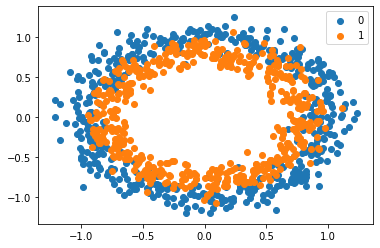

In [17]:
# scatter plot of the circles dataset with points colored by class
from sklearn.datasets import make_circles
from numpy import where
from matplotlib import pyplot
# generate circles
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
# select indices of points with each class label
for i in range(2):
	samples_ix = where(y == i)
	pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

A simple MLP model can be defined to address this problem that expects two inputs for the two features in the dataset, a hidden layer with 50 nodes, a rectified linear activation function and an output layer that will need to be configured for our loss function.
The model will be fit using stochastic gradient.
We will fit the model for 200 training epochs and evaluate the performance of the model against the loss and accuracy at the end of each epoch so that we can plot learning curves.

Train: 0.842, Test: 0.844


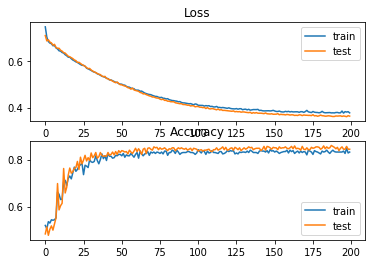

In [18]:
# mlp for the circles problem with cross entropy loss

# we already generated our 2d classification dataset

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

<div class="alert alert-warning">

**What does this code do ? What can you tell from the results ?**

<div class="alert alert-info"><a href="#code7" data-toggle="collapse">
    
**Solution note (click to unfold):** </a><br/>
    
<div id="code7" class="collapse">

<br>
Running the example first prints the classification accuracy for the model on the train and test dataset.
    
Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

In this case, we can see that the model learned the problem reasonably well, achieving about 83% accuracy on the training dataset and about 85% on the test dataset. The scores are reasonably close, suggesting the model is probably not over or underfit.

Train: 0.836, Test: 0.852
    
A figure is also created showing two line plots, the top with the cross-entropy loss over epochs for the train (blue) and test (orange) dataset, and the bottom plot showing classification accuracy over epochs.

The plot shows that the training process converged well. The plot for loss is smooth, given the continuous nature of the error between the probability distributions, whereas the line plot for accuracy shows bumps, given examples in the train and test set can ultimately only be predicted as correct or incorrect, providing less granular feedback on performance.

### Comparing cross-entropy to another loss function
We need another loss function to compare it to, otherwise this standalone analysis wouldn't yield any proof that cross-entropy is valuable here. for that matter, we develop an alternative to cross-entropy for binary classification problems with the hinge loss function, primarily developed for use with Support Vector Machine (SVM) models.

It is intended for use with binary classification where the target values are in the set {-1, 1}.

The hinge loss function encourages examples to have the correct sign, assigning more error when there is a difference in the sign between the actual and predicted class values.

Reports of performance with the hinge loss are mixed, sometimes resulting in better performance than cross-entropy on binary classification problems.

Firstly, the target variable must be modified to have values in the set {-1, 1}.

Train: 0.400, Test: 0.390


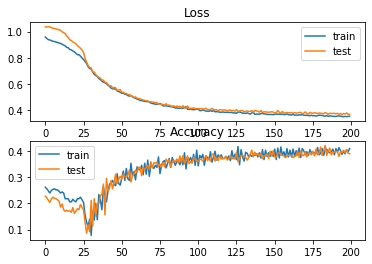

In [19]:
# generate 2d classification dataset
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
# change y from {0,1} to {-1,1}
y[where(y == 0)] = -1
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='tanh'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

<div class="alert alert-warning">

**What can you tell now from your previous analysis with cross-entropy ?**

<div class="alert alert-info"><a href="#code8" data-toggle="collapse">
    
**Solution note (click to unfold):** </a><br/>
    
<div id="code8" class="collapse">

<br>
Running the example first prints the classification accuracy for the model on the train and test dataset.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

In this case, we can see slightly worse performance than using cross-entropy, with the chosen model configuration with less than 80% accuracy on the train and test sets.

Train: 0.792, Test: 0.740

The plot of hinge loss shows that the model has converged and has reasonable loss on both datasets. The plot of classification accuracy also shows signs of convergence, albeit at a lower level of skill than may be desirable on this problem.

# <a id="sec3"></a> 3. Intuition for using Cross-entropy in ML problems

Given that an average cross-entropy loss of 0.0 is a perfect model, what do average cross-entropy values greater than zero mean exactly?

## <a id="sec3-1"></a> 3.1 Exploring the question in a binary classification problem 

The class labels are still 0 and 1 (a certain probability for one event and an impossible probability for the other event).

We can then calculate the cross entropy for different “predicted” probability distributions transitioning from a perfect match of the target distribution to the exact opposite probability distribution.

We would expect that as the predicted probability distribution diverges further from the target distribution that the cross-entropy calculated will increase.

The example below implements this and plots the cross-entropy result for the predicted probability distribution compared to the target of [0, 1].

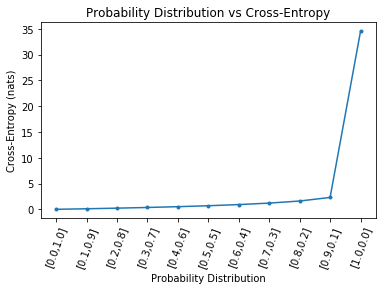

In [20]:
# cross-entropy for predicted probability distribution vs label

# calculate cross-entropy
def cross_entropy(p, q, ets=1e-15):
	return -sum([p[i]*log(q[i]+ets) for i in range(len(p))])

# define the target distribution for two events
target = [0.0, 1.0]
# define probabilities for the first event
probs = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
# create probability distributions for the two events
dists = [[1.0 - p, p] for p in probs]
# calculate cross-entropy for each distribution
ents = [cross_entropy(target, d) for d in dists]
# plot probability distribution vs cross-entropy
pyplot.plot([1-p for p in probs], ents, marker='.')
pyplot.title('Probability Distribution vs Cross-Entropy')
pyplot.xticks([1-p for p in probs], ['[%.1f,%.1f]'%(d[0],d[1]) for d in dists], rotation=70)
pyplot.subplots_adjust(bottom=0.2)
pyplot.xlabel('Probability Distribution')
pyplot.ylabel('Cross-Entropy (nats)')
pyplot.show()

This example calculates the cross-entropy score for each probability distribution then plots the results as a line plot.

We can see that as expected, cross-entropy starts at 0.0 (far left point) when the predicted probability distribution matches the target distribution, then steadily increases as the predicted probability distribution diverges.

We can also see a dramatic leap in cross-entropy when the predicted probability distribution is the exact opposite of the target distribution, that is, [1, 0] compared to the target of [0, 1].

We are not going to have a model that predicts the exact opposite probability distribution for all cases on a binary classification task.
As such, we can remove this case and re-calculate the plot.

The updated version of the code is listed below.

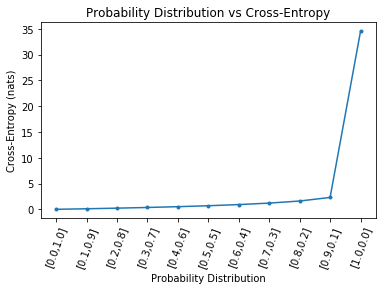

In [21]:
# plot probability distribution vs cross-entropy
pyplot.plot([1-p for p in probs], ents, marker='.')
pyplot.title('Probability Distribution vs Cross-Entropy')
pyplot.xticks([1-p for p in probs], ['[%.1f,%.1f]'%(d[0],d[1]) for d in dists], rotation=70)
pyplot.subplots_adjust(bottom=0.2)
pyplot.xlabel('Probability Distribution')
pyplot.ylabel('Cross-Entropy (nats)')
pyplot.show()

Running the example gives a much better idea of the relationship between the divergence in probability distribution and the calculated cross-entropy.

We can see a super-linear relationship where the more the predicted probability distribution diverges from the target, the larger the increase in cross-entropy.

## <a id="sec3-2"></a> 3.2 Interpreting cross-entropy 

A plot like this can be used as a guide for interpreting the average cross-entropy reported for a model for a binary classification dataset.

For example, you can use these cross-entropy values to interpret the mean cross-entropy reported by Keras for a neural network model on a binary classification task, or a binary classification model in scikit-learn evaluated using the logloss metric.

**You can use it to answer the general question : what is a good cross-entropy score?**

If you are working in nats (and you usually are) and you are getting mean cross-entropy less than 0.2, you are off to a good start, and less than 0.1 or 0.05 is even better.

On the other hand, if you are getting mean cross-entropy greater than 0.2 or 0.3 you can probably improve, and if you are getting a mean cross-entropy greater than 1.0, then something is going on and you’re making poor probability predictions on many examples in your dataset.

We can summarise these intuitions for the mean cross-entropy as follows :

<div class= "alert alert-success">

**Cross-Entropy = 0.00: Perfect probabilities.<br>
Cross-Entropy < 0.02: Great probabilities.<br>
Cross-Entropy < 0.05: On the right track.<br>
Cross-Entropy < 0.20: Fine.<br>
Cross-Entropy > 0.30: Not great.<br>
Cross-Entropy > 1.00: Terrible.<br>
Cross-Entropy > 2.00 Something is broken.**

This listing will provide a useful guide when interpreting a cross-entropy (log loss) from your logistic regression model, or your artificial neural network model.

You can also calculate separate mean cross-entropy scores per-class and help tease out on which classes you’re model has good probabilities, and which it might be messing up.

## Final word of advice :

In practice, a cross-entropy loss of 0.0 often indicates that the model has overfit the training dataset, but then it is up to you to dig behind the numbers.

# <a id="sec3"></a> 4. Bibliography

Uses and abuses of cross-entropy loss :
https://arxiv.org/pdf/2011.05231.pdf

Facebook research paper, Exploring the Limits of Weakly Supervised Pretraining :
https://research.fb.com/publications/exploring-the-limits-of-weakly-supervised-pretraining/

Improving the way neural networks learn :
http://neuralnetworksanddeeplearning.com/chap3.html

A Gentle Introduction to Cross-Entropy for Machine Learning :
https://machinelearningmastery.com/cross-entropy-for-machine-learning/

Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names :
https://gombru.github.io/2018/05/23/cross_entropy_loss/

How to Choose Loss Functions When Training Deep Learning Neural Networks :
https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

Categorical/Binary Cross-Entropy Loss :
https://www.youtube.com/watch?v=635cmrp4z40&feature=emb_logo

Cross-Entropy Loss Function :
https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

A Short Introduction to Entropy, Cross-Entropy and KL-Divergence :
https://www.youtube.com/watch?v=ErfnhcEV1O8